# Overview

Functionality implemented so far:
1. Read excel files and plot raw traces of graphs `plot_traces`
2. Find & calculate responding cells & make a new dataframe for values that pass threshold `calc_response_rate`
3. Graph max utp response for each slide `max_amp_plot`
4. Statistical significance: p-value and effect size `stats.ttest_ind` and `cohen_d`
5. Plot average values for control groups vs. L89A overexpressed groups `average_plot`

TODO's:
** Please open an issue for anything that should be implemented! **

# Code

## Imports

In [1]:
# Import modules for working with excel sheets and for plotting

# matplotlib: module for plotting
# pandas: module for working with dataframe (can be imported from excel, csv, txt)
# %: ipython magic, to plot graphs in line
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

In [2]:
# `PLOT' is a global variable that needs to be set to `True' to actually plot things in this notebook
PLOT = True

## Load Data

The following dataset is NOT on GitHub. Make sure your local directory structure is as follows:

                    repository_directory
                     /        \        \
                    /          \        \
                  code        assets    other files (.gitignore, README.md, LICENSE.txt, ...)
                   /            \
                  /              \
    <jupyter_notebook_file>    <data_file>
    
Also, if you want to use the functions in this script with another dataset, make sure to change `number_of_rows` 
and the file name in the following import statements.

In [3]:
# Import excel file as a `pandas.ExcelFile' object (which basically has all sub-sheets in a big container!)
# also, only import 1302 rows
number_of_rows = 1302
ca_data = pd.ExcelFile('../assets/2018-09-15 stable MB231 WT L89A 3 uM UTP Ca2+ free sorted.xlsx', nrows=number_of_rows)

## Functions

The following functions are used throughout this notebook to analyze and visualize data.
The doc-string should provide enough information on how they work. 
They basically encapsulate commonly used commands to make re-use easier!

In [4]:
# plot every single trace after reading subsheets and alphabetically sorting them
def plot_traces(df, plot=True):
    """
    this function takes a pandas.io.excel.ExcelFile object and iterates over all sheets
    every column of every such sheet is interpreted as a 'trace' and plotted in a line plot
    a new line plot is created for every sheet in the pandas.io.excel.ExcelFile object
    
    -------------------------a-----
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    plot      - defaults to False, if True, plot line plots for every sheet in `df'
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    for sheetname in sheetnames: 
        temp = pd.read_excel(df, sheetname)
        if plot:
            temp.plot(title=sheetname, legend=False)

In [5]:
# Find percentage of responding cells per slide and create a new dataframe for values that pass threshold
# Find average according to grouping
def calc_response_rate(df, threshold=1.2, utp_range=(40,480), verbose=False, plot=False):
    """
    this function calculates the response rate for calcium imaging data sets
    it takes a pandas.io.excel.ExcelFile and iterates over all data sheets and 
    columns in the input data frames to find the max value within the UTP range
    the max value is then compared with a threshold, if max value >= threshold, then the column is copied to a new data frame
    if value < threshold, value is not coppied to the new dataframe
    return a new data frame is created for each cell types only with columns of data the pass the threshold
    
    ------------------------------
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    threshold - defaults to 1.2, the response threshold for your dataset
    utp_range - defaults to (40,480), a tuple indicating the range in which to look 
    verbose   - defaults to False, if True, verbose output is printed (use it to suppress output)
    plot      - defaults to False, if True, plot boxplots to visualize computations
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    counter = 0
    col_counter = 0
    appended_data = []
    filtered_data = pd.DataFrame()
    for sheetname in sheetnames: 
        #print("this is a new sheet: {}".format(sheetname))
        selected_df = pd.read_excel(df, sheetname)[utp_range[0]:utp_range[1]]
        complete_df = pd.read_excel(df, sheetname)
        selected_df_max = selected_df.max()
        
        # counter in 1st but not 2nd loop so it's reset to 0 after every sheet but not after every column
        counter = 0
        col_counter = 0
        for idx in selected_df_max.index:
            col_counter += 1
            if selected_df_max[idx] >= threshold:
                new_col_name = sheetname + idx
                temp = {new_col_name: complete_df[idx]} 
                filtered_data = pd.concat([filtered_data, pd.DataFrame(temp)], axis=1)
            else:
                counter = counter + 1 # shorthand for this is: counter += 1, in cool languages (computer languages): counter++
        
        d = {'Sheet name':[sheetname], 'Total cells':[col_counter], 'Non-responding': [counter],'Percentage responding': [100-(counter*100/col_counter)]}
        data=pd.DataFrame(d)
        appended_data.append(data)
    
    appended_data = pd.concat(appended_data,ignore_index=True) 
    if verbose:
        print('Statistics for control cells')
        print(appended_data.loc[0:5].mean())
        print('Statistics for L89A cells')
        print(appended_data.loc[6:12].mean())
        
# return should be the last line of the function, because then the function stops/ returns
    return filtered_data


## Exploratory Data Analysis (*EDA*)

In [6]:
# call the newly created `plot_traces' function (output is suppressed)
plot_traces(df=ca_data, plot=False)

# call the newly created `calc_response_rate' function (output is suppressed)  
filtered_data = calc_response_rate(df=ca_data, threshold=1.1, utp_range=(40, 480), verbose=True, plot=False)

Statistics for control cells
Total cells              43.666667
Non-responding           10.166667
Percentage responding    76.685655
dtype: float64
Statistics for L89A cells
Total cells              38.333333
Non-responding            6.666667
Percentage responding    83.486712
dtype: float64


In [7]:
#step 1: Make a new empty dataframe outside the for loop
#step 2: To get desired column, [idx] --> type of a panda series
#step 3: 1st reinteration, concatenate new data frame 
#step 4: concatenate with next dataframe



def combined_data(df):
    """
    this function combines data from different 
    coverslips of the same cell type 
    into 1 data frame using regular expression
    
    ------------------------------
    arguments:
    df        - filtered data from `ca_response_rate` function
    """
    column_names = df.columns
    ctrl_data = pd.DataFrame()
    l89a_data = pd.DataFrame()

    #print(column_names)
    pattern = re.compile("CTRL.*")
    for column_name in column_names:
        if pattern.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            ctrl_data = pd.concat([ctrl_data, pd.DataFrame(temp1)], axis=1)
        else:
            temp2 = {column_name: filtered_data[column_name]}
            l89a_data = pd.concat([l89a_data, pd.DataFrame(temp2)], axis=1)
        
    return ctrl_data, l89a_data
            

In [8]:
ctrl_data, l89a_data = combined_data(df=filtered_data)

In [9]:
def max_amp_plot(df, utp_range=(40, 480), title='none'):
    """
    document me!
    """
    column_names = df.columns
    d = {}
    for column_name in column_names: 
        df_max = df.iloc[utp_range[0]:utp_range[1], :].max()
        df_max.plot.box(title=title) 
        
    return df_max

      

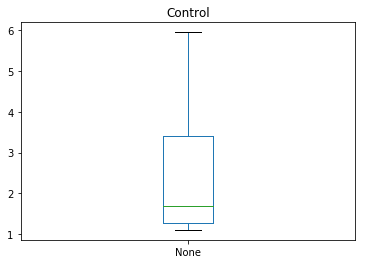

In [10]:
ctrl_max = max_amp_plot(df=ctrl_data, utp_range=(40, 480), title='Control')


#def max_amp_plot(df, col_names, utp_range=(40, 480), title):
#calc_response_rate(df=ca_data, threshold=1.2, utp_range=(40, 480), verbose=True, plot=True)

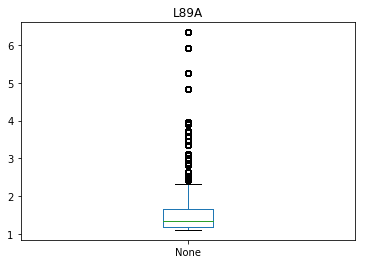

In [11]:
l89a_max = max_amp_plot(df=l89a_data, utp_range=(40, 480), title='L89A')

In [12]:
##scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')[source]
print(stats.ttest_ind(a=ctrl_max, b=l89a_max))

Ttest_indResult(statistic=6.312261869708858, pvalue=7.503398705037498e-10)


In [13]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [14]:
effect_size = cohen_d(x=ctrl_max, y=l89a_max)
print(effect_size)

#ctrl_max = max_amp_plot(df=ctrl_data, col_names=column_names, utp_range=(40, 480), title='Control')

0.638702413381654


In [15]:
def average_plot(df, title='none', legend=True, label='labels'):
    """
    document me!
    """
    df_mean = df.mean(axis=1)
    ax = df_mean.plot(title=title)
    ax.legend(labels=[label])

['CTRL', 'L89A']


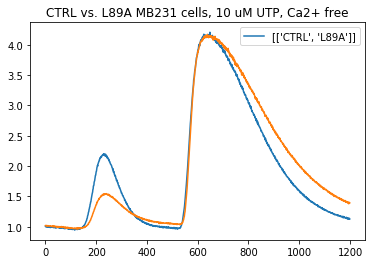

In [16]:
#average_plot(ctrl_data)
label=['CTRL','L89A']
print(label)
average_plot(df=ctrl_data,title='CTRL vs. L89A MB231 cells, 10 uM UTP, Ca2+ free', legend=True)
average_plot(df=l89a_data,title='CTRL vs. L89A MB231 cells, 10 uM UTP, Ca2+ free', legend=True, label=[label])

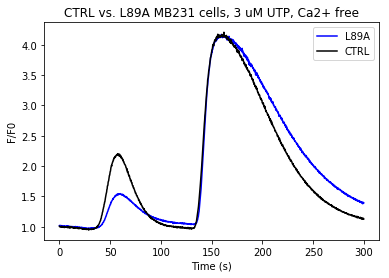

In [17]:
#Create a column of time
time = pd.DataFrame({'Time (s)': np.linspace(0,299.75,1200)})
ctrl_data_mean = ctrl_data.mean(axis=1)
l89a_data_mean = l89a_data.mean(axis=1)
fig, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('F/F0')
ax.set_title('CTRL vs. L89A MB231 cells, 3 uM UTP, Ca2+ free')
ax.plot(time, l89a_data_mean, '-b', label='L89A')
ax.plot(time, ctrl_data_mean, '-k', label='CTRL')
leg = ax.legend();

In [18]:
# first, a new data frame is create with just two columns:
#
#    | time | F/F0 | genotype |
#    | ---- | ---- | -------- |
#    | 0.25 | 1.13 | CTRL     |
#    | 0.5  | 1.08 | CTRL     |
#    | ...  | ...  | ...      |
#
# this data frame holds data from `time', `ctrl_data_mean', `l89a_data_mean'
ctrl_labels = ["CTRL" for i in ctrl_data_mean]
l89a_labels = ["L89K" for i in l89a_data_mean]
_ctrl_tmp = pd.DataFrame({"F/F0": ctrl_data_mean, "genotype": ctrl_labels})
_l89a_tmp = pd.DataFrame({"F/F0": l89a_data_mean, "genotype": l89a_labels})

ctrl_w_time = pd.concat([time, _ctrl_tmp], axis=1)
l89a_w_time = pd.concat([time, _l89a_tmp], axis=1)
mean_data_all = pd.concat([ctrl_w_time, l89a_w_time])

In [19]:
sns.__version__

'0.9.0'

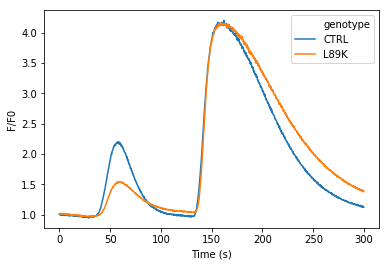

In [20]:
# second, the new object is plotted with seaborn's `catplot' function
sns.lineplot(x="Time (s)", y="F/F0", hue="genotype", data=mean_data_all,
             err_style="bars", ci=99);